In [1]:
%load_ext autoreload
%autoreload 2
notebook_fixed_dir = False

In [2]:
# this cell can only be called once
import os
if not notebook_fixed_dir:
    os.chdir('..')
    notebook_fixed_dir = True
print(os.getcwd())

/home/svcl-oowl/brandon/research/sil_consistent_at_inference


In [3]:
import pprint
import glob
from pathlib import Path
import pickle
import random

import torch
from PIL import Image
import numpy as np
from pytorch3d.renderer import look_at_view_transform
import matplotlib.pyplot as plt
import trimesh

import postprocess_dataset
from utils import utils
from utils import visualization_tools
from utils.eval_utils import eval_metrics
#from evaluation import compute_iou_2d, compute_iou_2d_given_pose, compute_iou_3d, compute_chamfer_L1

In [4]:
# displays meshes at the predicted pose
def show_meshes(input_dir_img, input_dir_mesh, refined_models_dir, gt_shapes_dict, device, only_show_instances=None, num_novel_view=3,
                metrics_to_eval=["2d_iou_input", "2d_iou_multi", "3d_iou","chamfer_L1"], num_sample_points=900000):
    

    # combining all cached predicted poses
    pred_poses_dict = {}
    pred_pose_paths = list(Path(refined_models_dir).rglob('pred_poses.p'))
    for pred_pose_path in pred_pose_paths:
        curr_cache = pickle.load(open(pred_pose_path, "rb"))
        pred_poses_dict = {**pred_poses_dict, **curr_cache}
    
    # getting paths of all processed meshes, keyed by instance name
    processed_paths = list(Path(refined_models_dir).rglob('*.obj'))
    processed_paths_dict = {}
    for path in processed_paths:
        instance_name = str(path).split('/')[-1][:-4]
        if instance_name not in processed_paths_dict:
            processed_paths_dict[instance_name] = [path]
        else:
            processed_paths_dict[instance_name].append(path)
    
    for instance_name in processed_paths_dict:
        if only_show_instances is None or instance_name in only_show_instances:
            for processed_mesh_path in processed_paths_dict[instance_name]:
                print(processed_mesh_path)
            
                input_image = Image.open(os.path.join(input_dir_img, instance_name+".png"))
                original_mesh_path = os.path.join(input_dir_mesh, instance_name+".obj")
                with torch.no_grad():
                    mesh_original = utils.load_untextured_mesh(original_mesh_path, device)
                    mesh_processed = utils.load_untextured_mesh(processed_mesh_path, device)
                mesh_original_trimesh = trimesh.load(original_mesh_path)
                mesh_processed_trimesh = trimesh.load(processed_mesh_path)
                
                pred_dist = pred_poses_dict[instance_name]['dist']
                pred_elev = pred_poses_dict[instance_name]['elev']
                pred_azim = pred_poses_dict[instance_name]['azim']
                
                # computing performance metrics
                if len(metrics_to_eval) > 0:
                    gt_mesh_path = gt_shapes_dict[instance_name]
                    with torch.no_grad():
                        mesh_gt = utils.load_untextured_mesh(gt_mesh_path, device)
                    mesh_gt_trimesh = trimesh.load(gt_mesh_path)
                    
                    metrics_dict_before, _ = eval_metrics(input_image, mesh_original_trimesh, mesh_original, mesh_gt_trimesh, mesh_gt,
                                                          device, metrics_to_eval, pred_azim, pred_elev, pred_dist, num_sample_points=num_sample_points)
                    metrics_dict_after, _ = eval_metrics(input_image, mesh_processed_trimesh, mesh_processed, mesh_gt_trimesh, mesh_gt,
                                                         device, metrics_to_eval, pred_azim, pred_elev, pred_dist, num_sample_points=num_sample_points)
                    
                    print("Metrics before refinement -- {}".format(metrics_dict_before))
                    print("Metrics after refinement -- {}".format(metrics_dict_after))
                
                visualization_tools.show_refinement_results(input_image, mesh_original, mesh_processed, pred_dist, pred_elev, pred_azim, device, num_novel_view)

In [11]:
# pix3d occnet gt
#class_name = "sofa"
#input_dir_mesh = "/home/svcl-oowl/brandon/research/occupancy_networks/out/pix3d/{}/generation/meshes".format(class_name)
#input_dir_img = "data/input_images/pix3d_images_processed_filtered/{}/rgba".format(class_name)
#gt_shapes_list_path = "data/gt_shapes_path_lists/pix3d_{}_gt_shapes.lst".format(class_name)
#refined_models_dir = "data/refinements/pix3d_occnet_refinements/gt_pose/{}".format(class_name)

# shapenet occnet gt
class_name = "03001627"
input_dir_mesh = "/home/svcl-oowl/brandon/research/occupancy_networks/out/pytorch3d_renders/{}/generation/meshes".format(class_name)
input_dir_img = "data/input_images/pytorch3d_shapenet_renders/{}/rgba".format(class_name)
gt_shapes_list_path = "data/gt_shapes_path_lists/shapenet_{}_gt_shapes.lst".format(class_name)
refined_models_dir = "data/refinements/shapenet_occnet_refinements/gt_pose/{}".format(class_name)

print(refined_models_dir)


data/refinements/shapenet_occnet_refinements/gt_pose/03001627


In [9]:
device = torch.device("cuda:0")
gt_shapes_dict = {}
with open(gt_shapes_list_path, 'r') as f:
    f = f.read().split('\n')
    for line in f:
        if line != "":
            gt_shapes_dict[line.split(" ")[0]] = line.split(" ")[1]

data/refinements/shapenet_occnet_refinements/gt_pose/03001627/batch_1_of_4/d4edd167061dac5f52a3901fa1436b1a.obj


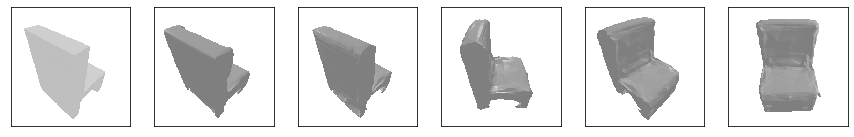

data/refinements/shapenet_occnet_refinements/gt_pose/03001627/batch_1_of_4/ce23daa630833de7d9fad8aba2c312b7.obj


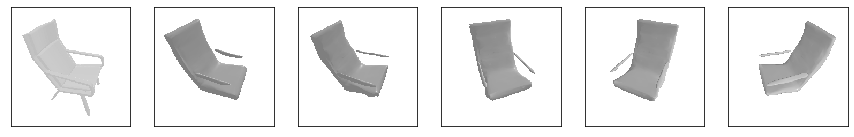

data/refinements/shapenet_occnet_refinements/gt_pose/03001627/batch_1_of_4/ccd5e24c9b96febd5208aab875b932bc.obj


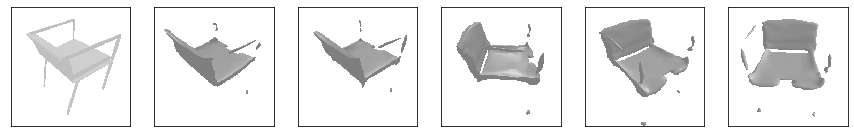

data/refinements/shapenet_occnet_refinements/gt_pose/03001627/batch_4_of_4/f76d50f900b034af19fb4103277a6b93.obj


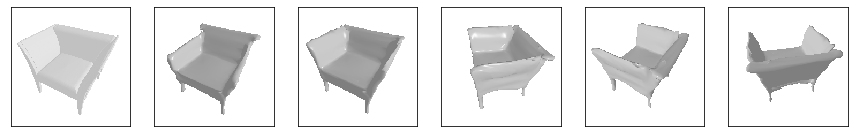

data/refinements/shapenet_occnet_refinements/gt_pose/03001627/batch_4_of_4/f33b6f791e9d64387d01b77e04a0bc7b.obj


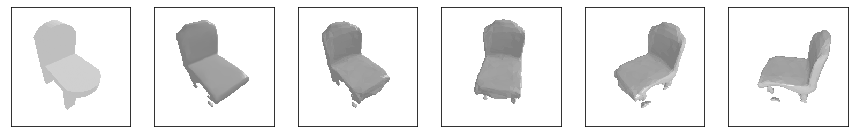

data/refinements/shapenet_occnet_refinements/gt_pose/03001627/batch_4_of_4/f55a514cc8f2d255f51f77a6d7299806.obj


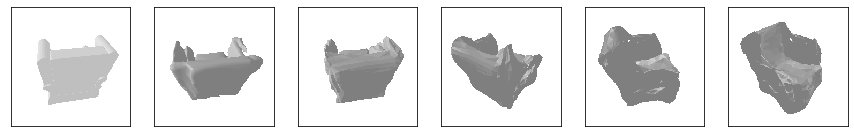

data/refinements/shapenet_occnet_refinements/gt_pose/03001627/batch_4_of_4/f268849e43f64861cb3a30f2c37c38a6.obj


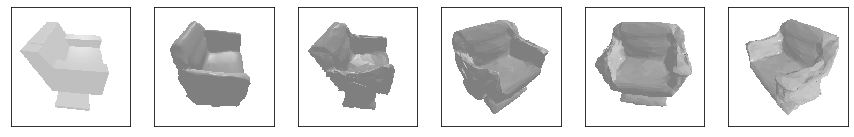

data/refinements/shapenet_occnet_refinements/gt_pose/03001627/batch_4_of_4/f2075f1c3088a167cf513de9a02a2561.obj


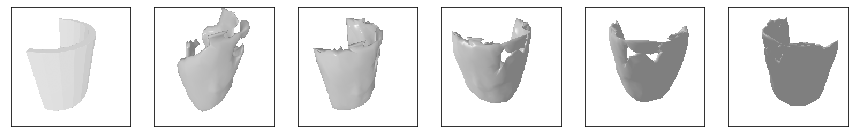

data/refinements/shapenet_occnet_refinements/gt_pose/03001627/batch_2_of_4/d8d5829083c66bd4f4b6538438a0b930.obj


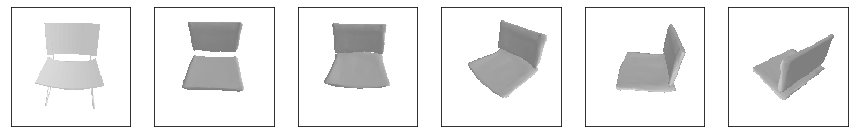

data/refinements/shapenet_occnet_refinements/gt_pose/03001627/batch_2_of_4/df6a3bc55f86781218930ac69342cc5c.obj


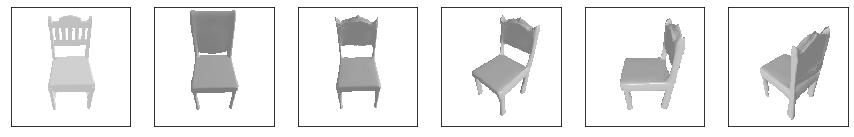

data/refinements/shapenet_occnet_refinements/gt_pose/03001627/batch_2_of_4/df487c3660e7030dc5ed74d70201d4c.obj


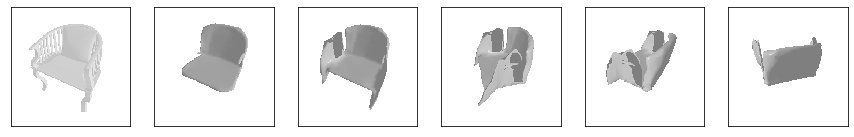

data/refinements/shapenet_occnet_refinements/gt_pose/03001627/batch_2_of_4/e065edba45aee481490ad276cd2af3a4.obj


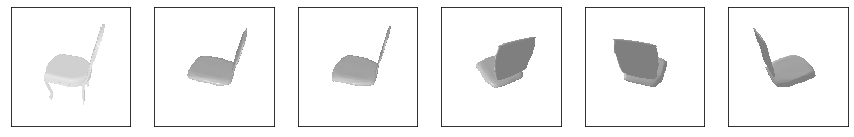

data/refinements/shapenet_occnet_refinements/gt_pose/03001627/batch_2_of_4/e00291d775c572f5e8f8c11a24c52ebb.obj


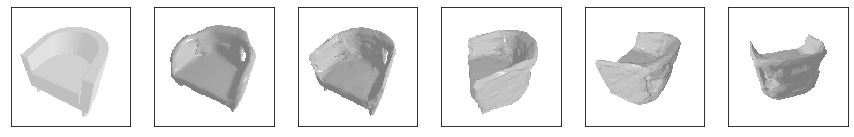

data/refinements/shapenet_occnet_refinements/gt_pose/03001627/batch_2_of_4/dcfd665cdc0b01e7b04cb542e2c50eb4.obj


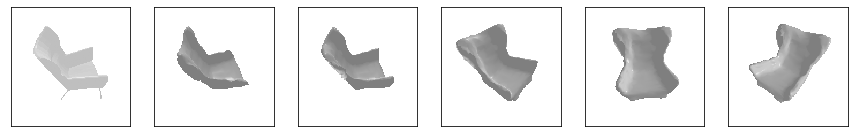

data/refinements/shapenet_occnet_refinements/gt_pose/03001627/batch_2_of_4/d7f35cad0f4ab17788dcbe86402c7c15.obj


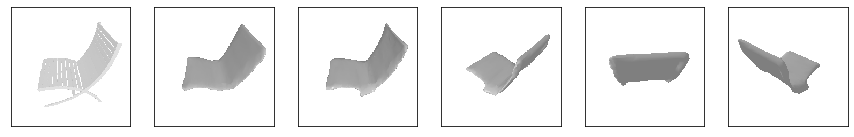

data/refinements/shapenet_occnet_refinements/gt_pose/03001627/batch_3_of_4/ef3377832d90dbbacfe150564cb24aad.obj


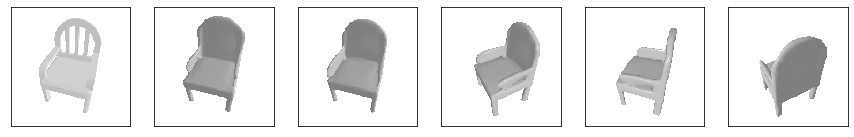

data/refinements/shapenet_occnet_refinements/gt_pose/03001627/batch_3_of_4/ebaf425ea2c92f73a3bafec3b56382db.obj


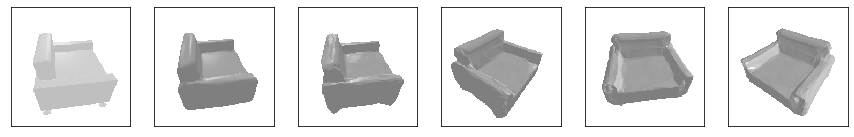

data/refinements/shapenet_occnet_refinements/gt_pose/03001627/batch_3_of_4/ece1a921c1bfd44947f5e245ee376525.obj


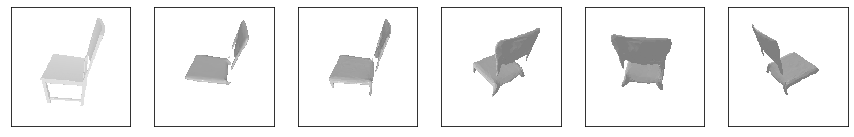

data/refinements/shapenet_occnet_refinements/gt_pose/03001627/batch_3_of_4/f00c1688bd33aae28cbb8bac2032149c.obj


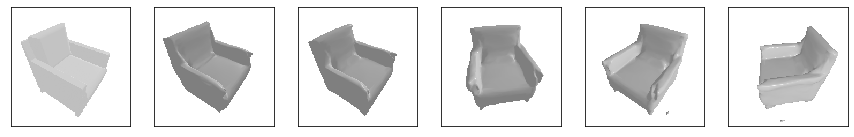

data/refinements/shapenet_occnet_refinements/gt_pose/03001627/batch_3_of_4/e9592e2a4fc74bf0492d9da2668ec34c.obj


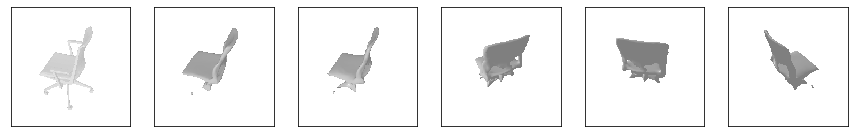

In [12]:
instances = random.sample([str(path).split('/')[-1].replace('.obj',"") for path in list(Path(refined_models_dir).rglob('*.obj'))], 20)
#m = ["2d_iou_input", "2d_iou_multi", "3d_iou","chamfer_L1"]
m = []
show_meshes(input_dir_img, input_dir_mesh, refined_models_dir, gt_shapes_dict, device, only_show_instances=instances, metrics_to_eval=m, num_sample_points=500000)

In [ ]:
# show training loss info
# getting paths of all loss info pickled files
input_dir_mesh = cfg['dataset']['input_dir_mesh']
output_dir = "{}_{}".format(input_dir_mesh, exp_name)
cached_loss_info_paths = list(Path(output_dir).rglob('loss_info.p'))

for path in cached_loss_info_paths:
    dataset_loss_info = pickle.load(open(path, "rb"))
    for instance_name in dataset_loss_info:
        loss_info = dataset_loss_info[instance_name]
        loss_info.plot.line(x='iteration', y='total_loss', title="{}".format(instance_name))
        #loss_info.plot.line(x='iteration', y='sil_loss')
        #loss_info.plot.line(x='iteration', y='img_sym_loss')
        #loss_info.plot.line(x='iteration', y='vertex_sym_loss')
        #loss_info.plot.line(x='iteration', y='l2_loss')
        #loss_info.plot.line(x='iteration', y='lap_smoothness_loss')
        #loss_info.plot.line(x='iteration', y='normal_consistency_loss')
        #loss_info.plot.line(x='iteration', y='semantic_dis_loss')